<a href="https://colab.research.google.com/github/jim-j-james/PadhAI_Deep_Learning/blob/main/0429_PyTorchCNN_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

* Downloading dataset (CIFAR10)
* `Dataloader` in `torch.utils`
* Visualising images
* Single and multiple convolutional layers
* LeNet
* Training LeNet
* Training on GPU
* Simple visualisation
* Exercises

In [1]:
#Import the relevent libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

## Exercises

* Modify LeNet to work with ReLU instead of Tanh -> What is the impact on training time, final loss
* We have observed over-fitting -> Use weight_decay in torch.optim to add L2 regularisation
* Instead of CIFAR10, use the MNIST data available from `torchvision.datasets.MNIST`. Download and visualise MNIST data.
* But importantly MNIST images have only 1 channel instead of 3 channels in the case of CIFAR10. Modify LeNet to work with MNIST. Train and find optimised test accuracy.

# Training LeNet with ReLU

In [2]:
# Modify LeNet to work with ReLU instead of Tanh -> What is the impact on training time, final loss

In [3]:
class LeNet_v1(nn.Module):
    def __init__(self): 
        super(LeNet_v1, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.ReLU(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.ReLU(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [4]:
#The batch size is taken as 128 as a power of 2 as GPU's work best on batc sizes with powere of 2
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
#Run the model on GPU for comparable results
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [7]:
net = LeNet_v1().to(device)
loss_fn = nn.CrossEntropyLoss()
#With out L2 Regularisation
#opt = optim.Adam(net.parameters())
#opt = optim.Adam(net.parameters(),lr=0.001)
#With L2 Regularisation
opt = optim.Adam(net.parameters(),lr=0.01,weight_decay=0.001)

Epoch: 0/100, Test acc: 37.71, Train acc: 37.84
Epoch: 1/100, Test acc: 40.17, Train acc: 41.25
Epoch: 2/100, Test acc: 41.91, Train acc: 41.93
Epoch: 3/100, Test acc: 44.50, Train acc: 44.92
Epoch: 4/100, Test acc: 43.35, Train acc: 44.56
Epoch: 5/100, Test acc: 44.62, Train acc: 45.94
Epoch: 6/100, Test acc: 46.62, Train acc: 47.30
Epoch: 7/100, Test acc: 47.13, Train acc: 48.04
Epoch: 8/100, Test acc: 46.28, Train acc: 47.98
Epoch: 9/100, Test acc: 46.89, Train acc: 47.84
Epoch: 10/100, Test acc: 48.42, Train acc: 50.27
Epoch: 11/100, Test acc: 48.84, Train acc: 50.62
Epoch: 12/100, Test acc: 48.96, Train acc: 50.18
Epoch: 13/100, Test acc: 49.23, Train acc: 50.06
Epoch: 14/100, Test acc: 49.89, Train acc: 51.26
Epoch: 15/100, Test acc: 50.77, Train acc: 51.95
Epoch: 16/100, Test acc: 50.21, Train acc: 52.13
Epoch: 17/100, Test acc: 51.00, Train acc: 52.90
Epoch: 18/100, Test acc: 48.96, Train acc: 50.49
Epoch: 19/100, Test acc: 50.99, Train acc: 52.44
Epoch: 20/100, Test acc: 51.18

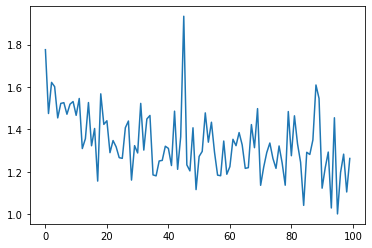

CPU times: user 17min 16s, sys: 4.94 s, total: 17min 21s
Wall time: 17min 19s


In [8]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 100

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

In [9]:
#w/o regularisation test acc is flattening/reducing and train accuracy is going up i.e. trin erro going down test error going up
'''
Epoch: 0/15, Test acc: 41.10, Train acc: 40.77
Epoch: 1/15, Test acc: 43.90, Train acc: 44.02
Epoch: 2/15, Test acc: 48.01, Train acc: 48.32
Epoch: 3/15, Test acc: 48.21, Train acc: 49.00
Epoch: 4/15, Test acc: 51.09, Train acc: 52.10
Epoch: 5/15, Test acc: 52.90, Train acc: 54.54
Epoch: 6/15, Test acc: 53.91, Train acc: 55.91
Epoch: 7/15, Test acc: 54.98, Train acc: 57.38
Epoch: 8/15, Test acc: 54.54, Train acc: 57.85
Epoch: 9/15, Test acc: 56.22, Train acc: 59.24
Epoch: 10/15, Test acc: 55.58, Train acc: 58.85
Epoch: 11/15, Test acc: 56.52, Train acc: 60.47
Epoch: 12/15, Test acc: 56.64, Train acc: 60.96
Epoch: 13/15, Test acc: 57.71, Train acc: 63.18
Epoch: 14/15, Test acc: 57.92, Train acc: 63.24
'''

'\nEpoch: 0/15, Test acc: 41.10, Train acc: 40.77\nEpoch: 1/15, Test acc: 43.90, Train acc: 44.02\nEpoch: 2/15, Test acc: 48.01, Train acc: 48.32\nEpoch: 3/15, Test acc: 48.21, Train acc: 49.00\nEpoch: 4/15, Test acc: 51.09, Train acc: 52.10\nEpoch: 5/15, Test acc: 52.90, Train acc: 54.54\nEpoch: 6/15, Test acc: 53.91, Train acc: 55.91\nEpoch: 7/15, Test acc: 54.98, Train acc: 57.38\nEpoch: 8/15, Test acc: 54.54, Train acc: 57.85\nEpoch: 9/15, Test acc: 56.22, Train acc: 59.24\nEpoch: 10/15, Test acc: 55.58, Train acc: 58.85\nEpoch: 11/15, Test acc: 56.52, Train acc: 60.47\nEpoch: 12/15, Test acc: 56.64, Train acc: 60.96\nEpoch: 13/15, Test acc: 57.71, Train acc: 63.18\nEpoch: 14/15, Test acc: 57.92, Train acc: 63.24\n'

In [10]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(testloader), evaluation(trainloader)))

Test acc: 54.61, Train acc: 56.43


In [11]:
#Test acc: 57.92, Train acc: 63.24 - w/o weight decay
#Test acc: 54.54, Train acc: 57.90 - With weight decay

## Data loading

In [13]:
#Download the MNIST dataset
import torchvision.transforms as transforms
trainset_MN = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
#Load the train data in batches of 4 while shuffling to create some randomness
trainloader_MN = torch.utils.data.DataLoader(trainset_MN, batch_size=4, shuffle=True)

In [15]:
#Declare an iter fucntion on the "trainloader" object and the next() function will load the first batch of images and labels.
dataiter_MN = iter(trainloader_MN)
images_MN, labels_MN = dataiter_MN.next()

#4 images from 1 batch,1 channel,28*28 image resolution
print(images_MN.shape)
print(labels_MN.shape)
print(labels_MN)

#1st Image,1 channels(R,G,B),28*28 image resolution
print(images_MN[1].shape)
#First image correspond to index 2
print(labels_MN[1].item())

torch.Size([4, 1, 28, 28])
torch.Size([4])
tensor([0, 0, 3, 4])
torch.Size([1, 28, 28])
0


## Visualise data

In [16]:
#Get the first impage which is of type Tensor
img = images_MN[1]
print(type(img))

<class 'torch.Tensor'>


In [17]:
#Convert to numpy and print the dimensions which is 1*28*28
npimg = img.numpy()
print(npimg.shape)

(1, 28, 28)


In [18]:
# To plot it correctly the dimensions need to be modifeid in the (x,y,z) form compared to the current format (z,x,y)
npimg = np.transpose(npimg, (1, 2, 0))
# Reshape the array into 28 x 28 array (2-dimensional array)
npimg = npimg.reshape((28, 28))
print(npimg.shape)

(28, 28)


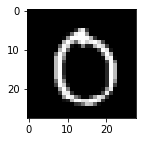

In [19]:
#The imshow can then display teh actual image abd the size is limited to (1,1) since the defualt size is very high.
#https://stackoverflow.com/questions/37228371/visualize-mnist-dataset-using-opencv-or-matplotlib-pyplot
plt.figure(figsize = (2,2))
plt.imshow(npimg,cmap='gray')
plt.show()

In [20]:
#The above steps are put in to function so that it can be called fora set of images
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    #npimg = npimg.reshape((28, 28))
    plt.figure(figsize = (3,3))
    plt.imshow(npimg,cmap='gray')
    plt.show()

#imshow(img)

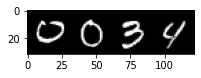

[0, 0, 3, 4]

In [21]:
#A grid is made out using the torchvision.utils.make_grid and imshow is applie don top of it to dicusplay the grid of 4 images in the batch
#https://pytorch.org/docs/stable/torchvision/utils.html
imshow(torchvision.utils.make_grid(images_MN))
#torchvision.utils.make_grid(images_MN)
#print(' '.join(classes[labels[j]] for j in range(4)))
#print(' '.join([labels_MN[j]] for j in range(4)))
labels_MN.tolist()

## Move to GPU

In [22]:
class LeNet_v2(nn.Module):
    def __init__(self): 
        super(LeNet_v2, self).__init__()
        self.cnn_model = nn.Sequential(
            #Input is (N, 1, 28, 28) and added padding of 2 to retain the o/p shape of (N,  6, 28, 28)
            nn.Conv2d(1, 6, 5, padding=2), # (N, 1, 28, 28) -> (N,  6, 28, 28)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.ReLU(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.ReLU(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [23]:
#The batch size is taken as 128 as a power of 2 as GPU's work best on batc sizes with powere of 2
batch_size = 128
trainset_MN = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader_MN = torch.utils.data.DataLoader(trainset_MN, batch_size=batch_size, shuffle=True)
testset_MN = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader_MN = torch.utils.data.DataLoader(testset_MN, batch_size=batch_size, shuffle=False)

In [24]:
#Run the model on GPU for comparable results
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [26]:
net = LeNet_v2().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/15, Test acc: 93.81, Train acc: 93.66
Epoch: 1/15, Test acc: 96.62, Train acc: 96.34
Epoch: 2/15, Test acc: 97.58, Train acc: 97.55
Epoch: 3/15, Test acc: 97.84, Train acc: 97.87
Epoch: 4/15, Test acc: 98.05, Train acc: 98.11
Epoch: 5/15, Test acc: 98.49, Train acc: 98.74
Epoch: 6/15, Test acc: 98.71, Train acc: 99.01
Epoch: 7/15, Test acc: 98.74, Train acc: 99.10
Epoch: 8/15, Test acc: 98.61, Train acc: 99.25
Epoch: 9/15, Test acc: 98.82, Train acc: 99.22
Epoch: 10/15, Test acc: 98.74, Train acc: 99.39
Epoch: 11/15, Test acc: 98.83, Train acc: 99.42
Epoch: 12/15, Test acc: 99.05, Train acc: 99.62
Epoch: 13/15, Test acc: 98.90, Train acc: 99.59
Epoch: 14/15, Test acc: 98.81, Train acc: 99.53


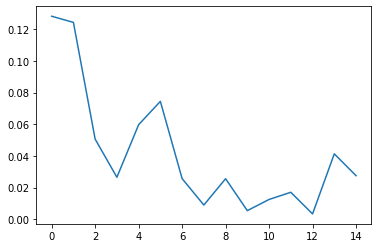

CPU times: user 2min 13s, sys: 698 ms, total: 2min 13s
Wall time: 2min 13s


In [27]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 15

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader_MN, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader_MN), evaluation(trainloader_MN)))

plt.plot(loss_epoch_arr)
plt.show()

In [28]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(testloader_MN), evaluation(trainloader_MN)))

Test acc: 98.81, Train acc: 99.53
